In [1]:
import sys
import os

# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))
import numpy as np
import pandas as pd
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from multiprocessing import Pool, cpu_count
from ase import Atoms
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
# Load the saved dataframe
df = pd.read_pickle(f"../dataset/symmetrized_dataset.pkl")

In [2]:
# Interpolation function
energy_min = 0.0
energy_max = 30.0
nstep = 301
new_x = np.linspace(energy_min, energy_max, nstep, dtype=np.float64)

def interpolate_matrix(matrix, omega, new_grid=new_x):
    """High-precision interpolation of a (N, 3, 3) tensor along the energy axis."""
    omega = np.asarray(omega, dtype=np.float64)
    matrix = np.asarray(matrix, dtype=np.float64)
    
    interp = interp1d(
        omega,
        matrix,
        kind='linear',
        axis=0,
        fill_value=0,  # instead of 0
        bounds_error=False
    )
    return interp(new_grid)  # Returns shape (nstep, 3, 3)
def log_transform_matrix(matrix):
    """
    Apply log transformation to a 3D matrix (N, 3, 3).
    Transform each element: log(abs(value)) and adjust for sign.
    Avoid log(0) by adding a small constant (1e-18).
    """
    return np.sign(matrix) * np.log(np.abs(matrix) + 1e-18)
def exp_transform_matrix(matrix_log):
    """
    Inverse of log transformation: exponentiate back to the original scale.
    """
    return np.sign(matrix_log) * np.exp(np.abs(matrix_log))


# Apply interpolation to imag and real permittivity matrices
df['imag_Permittivity_Matrices_interp'] = [
    # exp_transform_matrix(interpolate_matrix(log_transform_matrix(row['imag_symmetrized_permittivity']),row['omega'])) for _, row in df.iterrows()
    interpolate_matrix(row['imag_symmetrized_permittivity'],row['omega']) for _, row in df.iterrows()
]
df['real_Permittivity_Matrices_interp'] = [
    # exp_transform_matrix(interpolate_matrix(log_transform_matrix(row['imag_symmetrized_permittivity']),row['omega'])) for _, row in df.iterrows()
    interpolate_matrix(row['real_symmetrized_permittivity'],row['omega']) for _, row in df.iterrows()
]

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams["mathtext.fontset"] = "cm"
fontsize = 24
textsize = 16
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize
plt.rcParams['text.usetex'] = False

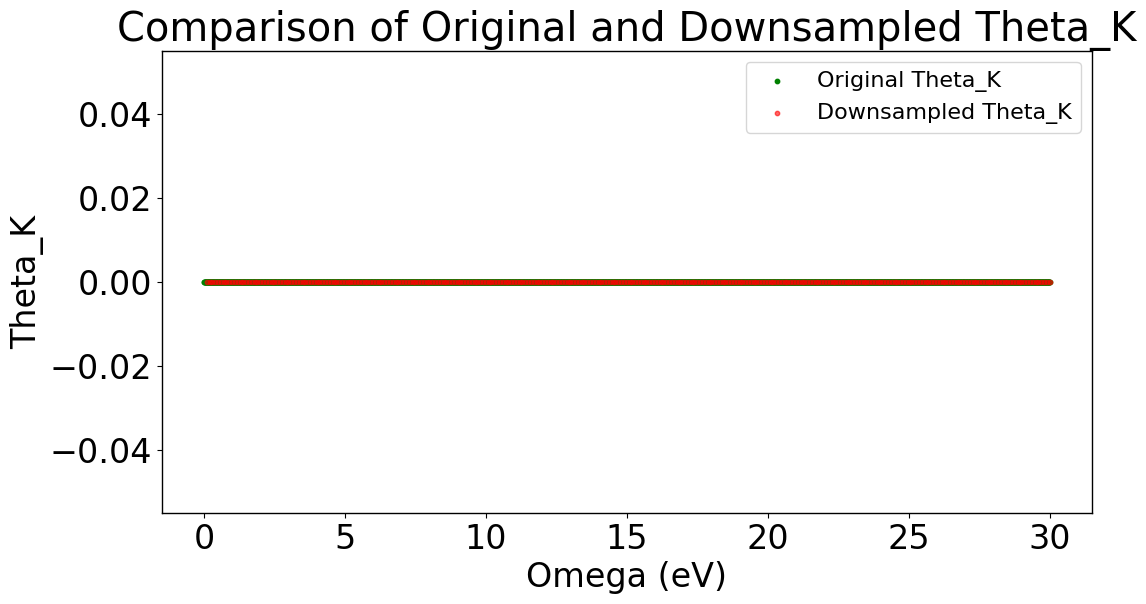

In [4]:
def plot_comparison(df):
    for _, row in df.iterrows():
        plt.figure(figsize=(12, 6))
        plt.scatter(row["omega"][1:], row["imag_symmetrized_permittivity"][1:,0,1], label="Original Theta_K", s=10, color='green')
        plt.scatter(new_x[1:], row["imag_Permittivity_Matrices_interp"][1:,0,1], label="Downsampled Theta_K", alpha=0.6, s=10, color='red')
        plt.xlabel("Omega (eV)")
        plt.ylabel("Theta_K")
        plt.legend()
        plt.title("Comparison of Original and Downsampled Theta_K")
        plt.show()

        # # Plot comparison for epsilon_K
        # plt.figure(figsize=(12, 6))
        # plt.scatter(row["omega"], row["epsilon_K_original"], label="Original Epsilon_K", s=10, color='green')
        # plt.scatter(new_x, row["epsilon_K_downsampled"], label="Downsampled Epsilon_K", alpha=0.6, s=10, color='red')
        # plt.xlabel("Omega (eV)")
        # plt.ylabel("Epsilon_K")
        # plt.legend()
        # plt.title("Comparison of Original and Downsampled Epsilon_K")
        # plt.show()
        
# plot_comparison(df[df["crystal_system"] != "triclinic"].head(5))

plot_comparison(df[df["formula"] == "Cd2P8"])


In [5]:
from matplotlib.ticker import MaxNLocator

def format_chemical_formula(formula):
    if not formula:
        return formula
    result = ''
    i = 0
    while i < len(formula):
        char = formula[i]
        if char.isalpha():
            element = char
            i += 1
            if i < len(formula) and formula[i].islower():
                element += formula[i]
                i += 1
            result += element
            number = ''
            while i < len(formula) and formula[i].isdigit():
                number += formula[i]
                i += 1
            if number:
                result += f'_{{{number}}}'
            if i < len(formula) and formula[i] == '^':
                i += 1
                superscript = ''
                while i < len(formula) and (formula[i].isdigit() or formula[i] in ['+', '-']):
                    superscript += formula[i]
                    i += 1
                if superscript:
                    result += f'^{{{superscript}}}'
        else:
            result += char
            i += 1
    return result

In [6]:
df[df.crystal_system=="monoclinic"].head(5)

,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,species,real_symmetrized_permittivity,imag_symmetrized_permittivity,imag_Permittivity_Matrices_interp,real_Permittivity_Matrices_interp
4,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Te, Al]","[[[3.57865600493003, 0.0, 0.0588499476841695],...","[[[-2.370171074423322e-18, 0.0, 3.360404376639...","[[[-2.370171074423322e-18, 0.0, 3.360404376639...","[[[3.57865600493003, 0.0, 0.0588499476841695],..."
9,K2N2O4,"(Atom('K', [1.6344779397874578, 2.85435, 3.535...",mp-34857,2.5157,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[N, K, O]","[[[0.49654299983035355, 0.0, 0.059351535522716...","[[[7.02034209063955e-18, 0.0, 7.77888869879604...","[[[7.02034209063955e-18, 0.0, 7.77888869879604...","[[[0.49654299983035355, 0.0, 0.059351535522716..."
29,Ag2Cl2,"(Atom('Ag', [0.8826498248353902, 0.9805, 4.150...",mp-1536202,0.7132,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Ag, Cl]","[[[1.9176513866525517, 0.0, -0.007608154997165...","[[[1.2570154618370575e-18, 0.0, 1.020873144709...","[[[1.2570154618370575e-18, 0.0, 1.020873144709...","[[[1.9176513866525517, 0.0, -0.007608154997165..."
33,Nb4O10,"(Atom('Nb', [11.046802477128768, 0.0, 3.744692...",mp-1595,2.1710,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[O, Nb]","[[[2.4118381976865955, 0.0, 0.1566827277736127...","[[[-1.1584711464161235e-17, 0.0, -1.5624874616...","[[[-1.1584711464161235e-17, 0.0, -1.5624874616...","[[[2.4118381976865955, 0.0, 0.1566827277736127..."
35,Cu4Hg2I8,"(Atom('Cu', [-2.1211768070430423, 6.4557391200...",mp-1545909,0.6183,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[I, Hg, Cu]","[[[3.2391613024839967, 0.0, 0.0236827208130192...","[[[-2.9515822648161005e-17, 0.0, 2.73874961111...","[[[-2.9515822648161005e-17, 0.0, 2.73874961111...","[[[3.2391613024839967, 0.0, 0.0236827208130192..."


In [7]:
row = df[df["formula"] == "K2N2O4"].iloc[0]
# Extract data
omega = row.omega
imag_permittivity = row["imag_symmetrized_permittivity"]
imag_permittivity_interp = row["imag_Permittivity_Matrices_interp"]
# Settings
xyz_list = ['x', 'y', 'z']
figsize = (15, 8)

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True, dpi = 1200)
axes = axes.flatten()

component_idx = 0
lines = []
labels = []
maes = []

global_abs_max = np.max(np.abs(imag_permittivity))
global_abs_min = np.min((imag_permittivity))
for i in range(3):
    for j in range(i, 3):
        ax = axes[component_idx]
        comp_label = rf"$\chi_{{{xyz_list[i]}{xyz_list[j]}}}$"

        l1 = ax.plot(omega, imag_permittivity[:, i, j], color='black', label='Original', linewidth=2)[0]
        l2 = ax.scatter(new_x, imag_permittivity_interp[:, i, j], color='red', label='Interpolated', s=10)

        # Optional: zero line for context        
        ax.set_ylim((global_abs_min-0.5) * 1.2, global_abs_max * 1.1)

        ax.set_title(f"{comp_label} ", fontsize=fontsize + 2)

        if component_idx == 0:
            lines.extend([l1, l2])
            labels.extend([l.get_label() for l in (l1, l2)])

        component_idx += 1
# Hide unused subplots if any
for k in range(component_idx, len(axes)):
    fig.delaxes(axes[k])


formula = format_chemical_formula(row["formula"])
crystal_sys = row["crystal_system"]
# Super (global) axis labels
fig.suptitle(rf"${formula}$ {crystal_sys} system", y=0.92)
fig.supxlabel("Photon energy (eV)", fontsize=fontsize + 2, y=0.07)
fig.supylabel("Permittivity real part (F/m)", fontsize=fontsize + 2)

# Shared legend below all plots
fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=fontsize,  bbox_to_anchor=(0.5, 0.1),frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout
plt.show()
